## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Descriptive Statistics](#descriptive)
- [Part II - Probability](#probability)
- [Part III - Experimentation](#experimentation)
- [Part IV - Algorithms](#algorithms)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='descriptive'></a>
#### Part I - Descriptive Statistics

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(0)

In [2]:
# Load CSV
df = pd.read_csv('ab_data.csv')
df.head()

,country,group,converted
0,UK,control,0
1,US,treatment,1
2,UK,treatment,0
3,UK,control,0
4,UK,treatment,0


In [3]:
df.shape[0] # Number of Rows

69889

In [4]:
df["converted"].mean() # Probability users convert in this dataset.

np.float64(0.13047832992316388)

In [5]:
df.info() # Check for nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69889 entries, 0 to 69888
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    69889 non-null  object
 1   group      69889 non-null  object
 2   converted  69889 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [6]:
# number of visitors from each country
df['country'].value_counts()

country
US    48850
UK    17551
CA     3488
Name: count, dtype: int64

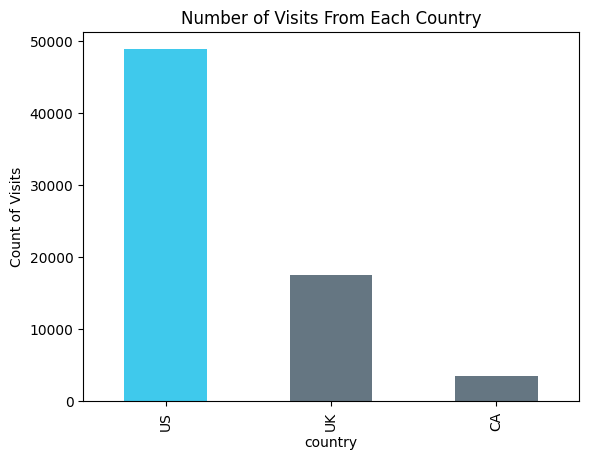

In [7]:
# bar chart of results
df['country'].value_counts().plot(kind='bar', color=['#3fc9ec', '#657682', '#657682']);
plt.title('Number of Visits From Each Country');
plt.ylabel('Count of Visits');
plt.show();

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69889 entries, 0 to 69888
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    69889 non-null  object
 1   group      69889 non-null  object
 2   converted  69889 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


> The `converted` column is the only non categorical column

In [9]:
# Possible values in the converted column.
df.converted.value_counts()

converted
0    60770
1     9119
Name: count, dtype: int64

0 and 1 only. Makes sense as a user is either converted (clicked on the button) or not. There are no other possibilities.

<a id='probability'></a>
#### Part II - Probability

* Now that we have had a chance to learn more about the dataset, let's look more at how different factors are related to `converting`.

In [10]:
df.converted.mean() # probability of an individual converting regardless of the page or country

np.float64(0.13047832992316388)

In [11]:
df.query('group == "control"')['converted'].mean() # Probability of conversion if a user is in the control group

np.float64(0.1052540515600669)

In [12]:
df.query('group == "treatment"')['converted'].mean() # Probability of conversion if a user is in the control group

np.float64(0.15532078043793132)

**There's a difference!** 16% is certainly more than 11%

In [13]:
len(df.query('group == "treatment"')) / len(df) # Proportion of treatment users

0.5038131894861853

In [14]:
len(df.query('country == "CA"')) / len(df) # Proportion of users from Canada

0.04990771079855199

In [15]:
df.query('country == "US"')['converted'].mean() # Probability of conversion for users in the US

np.float64(0.13277379733879222)

In [16]:
df.query('country == "UK"')['converted'].mean() # Probability of conversion for users in the UK

np.float64(0.12512107572218106)

12.5% is different from 13.3% but the difference is not that high.

In [17]:
df.groupby(['country', 'group'])['converted'].mean() # conversion rates by country and treatment group

country  group    
CA       control      0.094474
         treatment    0.154017
UK       control      0.101649
         treatment    0.148698
US       control      0.107314
         treatment    0.157769
Name: converted, dtype: float64

|             | US          | UK          | CA          |
| ----------- | ----------- | ----------- | ----------- |
| Control     | 10.7%       | 10.2%       | 09.4%       |
| Treatment   | 15.8%       | 14.9%       | 15.4%       |

In [18]:
# Group by 'group' and calculate mean conversion rate and beautify it
table = df.groupby(['group', 'country'])['converted'].mean()
table = table.apply(lambda x: str(round(x*100, 1))+"%").reset_index()

# Pivot the table
table = table.pivot(index='group', columns='country', values='converted')

# Remove the word "country" and "group" from the table
table.columns.name = None
table = table.rename_axis("", axis=0)

# Sort
table = table[sorted(table, reverse=True)]

table

,US,UK,CA
,,,
control,10.7%,10.2%,9.4%
treatment,15.8%,14.9%,15.4%


<a id='experimentation'></a>
### Part III - Experimentation

* Let's assume that the control page is better unless the treatment page proves to be definitely better at a Type I error rate of 5%. Consequently, I state my null and alternative hypotheses in terms of **$p_{control}$** and **$p_{treatment}$** as:  

$H_{0}: p_{control} >= p_{treatment}$

$H_{1}: p_{control} < p_{treatment}$

Which is equivalent to:

$H_{0}: p_{treatment} - p_{control} <= 0$

$H_{1}: p_{treatment} - p_{control} > 0$


Where  
* **$p_{control}$** is the `converted` rate for the control page
* **$p_{treatment}$** `converted` rate for the treatment page

**Note for this experiment we are not looking at differences associated with country.**

To make the test easier, I assume that under the null hypothesis, $p_{treatment}$ and $p_{control}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{treatment}$ and $p_{control}$ are equal. Furthermore, I assume that they are equal to the **converted** rate in `df` regardless of the page.

In [19]:
p_control_treatment_null  = df['converted'].mean() # Convert rate for both P treatment and P control under the null.
n_treatment = df.query('group == "treatment"').shape[0] # Control Sample Size
n_control = df.query('group == "control"').shape[0] # Treatment Sample Size
p_control_treatment_null, n_treatment, n_control

(np.float64(0.13047832992316388), 35211, 34678)

In [20]:
# Simulate n_treatment interactions with a convert rate of p_treatment_null
treatment_converted = np.random.binomial(1, p_control_treatment_null, n_treatment)

In [21]:
# Simulate n_control interactions with a convert rate of p_control_null
control_converted = np.random.binomial(1, p_control_treatment_null, n_control)

In [22]:
# Estimate P_treatment - P_control using the previous simulated values
p_treatment = treatment_converted.mean()
p_control = control_converted.mean()

p_treatment - p_control

np.float64(0.0015499083246634238)

In [23]:
p_diffs = []
# Bootstrap with 500 iterations and a sample size of n_control and n_treatment for the simulated interactions for control and treatment groups respectively
for _ in range(500):
    # simulate the treatment and control converted arrays
    treatment_converted = np.random.binomial(1, p_control_treatment_null, n_treatment)
    control_converted = np.random.binomial(1, p_control_treatment_null, n_control)
    # calculate p_treatment and p_control under the null
    p_treatment_null = treatment_converted.mean()
    p_control_null = control_converted.mean()
    # calculate the difference between p_treatment_null and p_control_null
    p_diff = p_treatment_null - p_control_null
    # add p_diff to the p_diffs array
    p_diffs.append(p_diff)

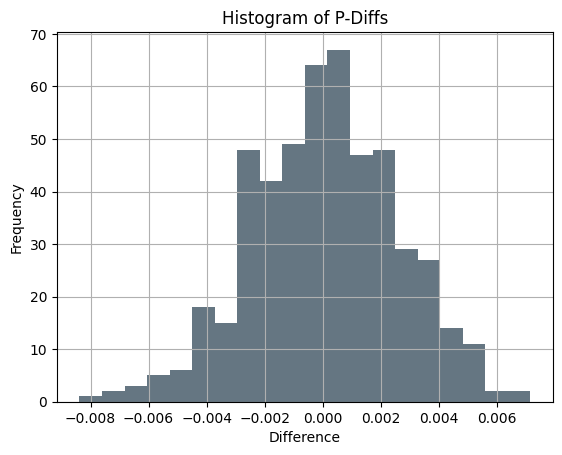

In [24]:
# Visualize the series
p_diffs = pd.Series(p_diffs) # convert to series
p_diffs.hist(bins=20, color="#657682") # set amount of bins and 
plt.title("Histogram of P-Diffs")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show()

It has a **normal distribution!** (bell curve).

In [25]:
# Compute the actual difference observed in the main dataset
actual_diff = df.query('group == "treatment"')['converted'].mean() - df.query('group == "control"')['converted'].mean()
actual_diff

np.float64(0.050066728877864425)

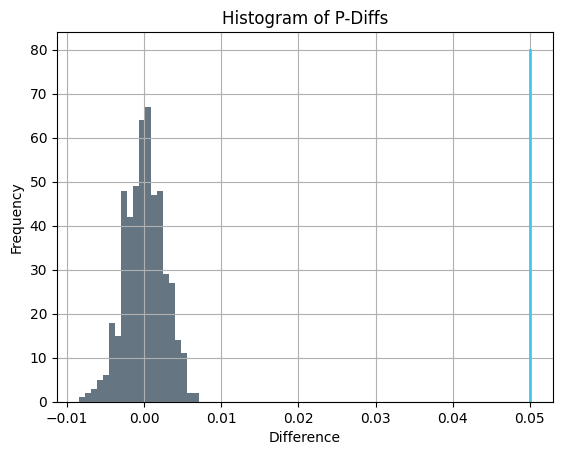

In [26]:
# Visually show the actual difference
p_diffs = pd.Series(p_diffs)
p_diffs.hist(bins=20, color="#657682")
plt.plot([actual_diff, actual_diff], [0, 80], '-', lw=2, color="#3fc9ec")
plt.title("Histogram of P-Diffs")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show()

It is very apparent that all computed differences under the null hypothesis are way 

In [27]:
len(p_diffs[p_diffs > actual_diff]) / len(p_diffs) # Compute the p-value (or the proportion of computed differences that are larger than actual difference)

0.0

> This is called the p-value. If the p-value is greater than 0.05, then we fail to reject the null hypothesis. Otherwise, we reject the null hypothesis. In this case, the p-value is 0 (no value is larger than the actual obsereved), so we  reject the null hypothesis and this shows us that the **Treatment** page has higher conversion rates.

<a id='algorithms'></a>
### Part IV - Algorithms

These results can also be acheived by performing regression.


Since each row is either a conversion or no conversion, I should use **Logistic Regression**.

In [28]:
# Prepare data to get fitted.
df['intercept'] = 1 # Set intercept
df['ab_page'] = pd.get_dummies(df['group'])['treatment'].astype(int) # Get dummies (convert to 0s and 1s)
df.head()

,country,group,converted,intercept,ab_page
0,UK,control,0,1,0
1,US,treatment,1,1,1
2,UK,treatment,0,1,1
3,UK,control,0,1,0
4,UK,treatment,0,1,1


In [29]:
X = df[['intercept', 'ab_page']] # Create the X matrix passed to the model
y = df['converted'] # Create the response passed to the model

In [30]:
import statsmodels.api as sm

In [31]:
# Logit Model to test if there is a difference in conversions in the treatment page vs the control page
logit_mod = sm.Logit(y, X)
logit_res = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.384516
         Iterations 6


In [32]:
print(logit_res.summary2())

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: converted        Pseudo R-squared: 0.007     
Date:               2024-07-23 23:28 AIC:              53750.8788
No. Observations:   69889            BIC:              53769.1882
Df Model:           1                Log-Likelihood:   -26873.   
Df Residuals:       69887            LL-Null:          -27068.   
Converged:          1.0000           LLR p-value:      1.8101e-86
No. Iterations:     6.0000           Scale:            1.0000    
------------------------------------------------------------------
             Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
intercept   -2.1402    0.0175  -122.3047  0.0000  -2.1745  -2.1059
ab_page      0.4467    0.0229    19.5389  0.0000   0.4019   0.4915



The p-value associated with **ab_page** is **0**, which is the same p-value got in the **Experiment** section, leading to the same conclusion: we reject the null hypothesis. The **treatment** page is better in converting users than the control page. This may be due to users loving a new design, or that the new design makes the click easier to access and more visually appealing.

`2. a)` Now you will want to create two new columns as dummy variables for `US` and `UK`.  Again, use `get_dummies` to add these columns.  The dataframe you create should include at least the following columns (If both columns for `US` and `UK` are `0` this represents `CA`.  The order of rows and columns is not important for you to match - it is just to illustrate how columns should connect to one another.):

##### Example DataFrame
| intercept   | group       | ab_page     | converted   | country     |  US         | UK          |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| 1           |  control    |  0          |  0          |  US         |  1          |  0          |
| 1           |  treatment  |  1          |  0          |  UK         |  0          |  1          |
| 1           |  treatment  |  1          |  0          |  US         |  1          |  0          |
| 1           |  control    |  0          |  0          |  US         |  1          |  0          |
| 1           |  treatment  |  1          |  1          |  CA         |  0          |  0          |
| 1           |  treatment  |  1          |  1          |  UK         |  0          |  1          |
| 1           |  treatment  |  1          |  0          |  US         |  1          |  0          |
| 1           |  control    |  0          |  1          |  US         |  1          |  0          |

In [33]:
### Create the necessary dummy variables
df[["US", "UK"]] = pd.get_dummies(df["country"])[["US", "UK"]].astype(int)

In [34]:
df["intercept"] = 1 # Create an intercept
X = df[["intercept", "ab_page", "US", "UK"]] # Create the X matrix passed to the model
y = df["converted"] # Create the response passed to the model

Here, we are testing if there is 
* a difference in `converted` between `treatment` vs. `control`
* a difference in `converted` between `US`, `UK`, and `CA`

In [35]:
logit_mod2 = sm.Logit(y, X)
logit_res2 = logit_mod2.fit() # fit the model

Optimization terminated successfully.
         Current function value: 0.384463
         Iterations 6


In [36]:
logit_res2.summary2() # Show summary

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: converted        Pseudo R-squared: 0.007     
Date:               2024-07-23 23:28 AIC:              53747.4949
No. Observations:   69889            BIC:              53784.1135
Df Model:           3                Log-Likelihood:   -26870.   
Df Residuals:       69885            LL-Null:          -27068.   
Converged:          1.0000           LLR p-value:      1.7779e-85
No. Iterations:     6.0000           Scale:            1.0000    
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
intercept    -2.1930    0.0531  -41.3083  0.0000  -2.2970  -2.0889
ab_page       0.4466    0.0229   19.5338  0.0000   0.4018   0.4914
US            0.0727    0.0530    1.3718  0.1701  -0.0312   0.1766
UK            0.0067    0.0562    0.1196  0.9048  -0.1033   0.1168
=================================================================

"""

In [37]:
np.exp(0.4466)

np.float64(1.5629889786391706)

The **treatment** page is 1.56 times more likely to convert users than the **control** page.

The p-values associated with US and UK suggest that the `country` is not statistically significant to determine whether users will convert or not.